# __LeNet - MXNet (From Scratch)__

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

In [2]:
def transform(data, label):
    return data.transpose((2, 0, 1)).astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.MNIST(train = False, transform = transform)

In [3]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(1, 28, 28)
0.0


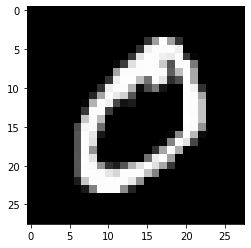

In [4]:
plt.imshow(image[0].asnumpy(), 'gray')
plt.show()

## __Defining data loaders__

In [5]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = False)

## __Defining LeNet Model Architecture__

In [6]:
model = nn.HybridSequential()

model.add(nn.Conv2D(channels = 6, kernel_size = (5, 5), strides = (1, 1)))
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(nn.Conv2D(channels = 16, kernel_size = (5, 5), strides = (1, 1)))
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(nn.Flatten())

model.add(nn.Dense(120, activation = 'relu'))
model.add(nn.Dense(84, activation = 'relu'))
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Activation(relu)
  (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (3): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Activation(relu)
  (5): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (6): Flatten
  (7): Dense(None -> 120, Activation(relu))
  (8): Dense(None -> 84, Activation(relu))
  (9): Dense(None -> 10, linear)
)

## __Summarizing the model__

In [7]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
            Conv2D-1                              (1, 6, 24, 24)             156
        Activation-2                              (1, 6, 24, 24)               0
         MaxPool2D-3                              (1, 6, 12, 12)               0
            Conv2D-4                               (1, 16, 8, 8)            2416
        Activation-5                               (1, 16, 8, 8)               0
         MaxPool2D-6                               (1, 16, 4, 4)               0
           Flatten-7                                    (1, 256)               0
        Activation-8                    <Symbol dense0_relu_fwd>               0
        Activation-9                                    (1, 120)               0
            Dense-10        

## __Visualizing model architecture__

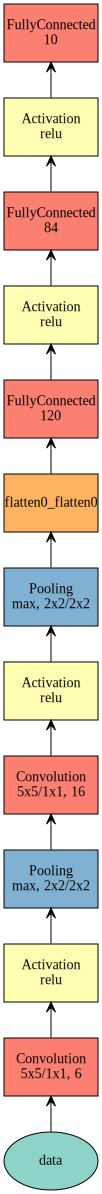

In [8]:
mx.viz.plot_network(model(mx.sym.var(name = 'data', shape = (1, 1, 28, 28))))

By hybridizing the model becomes almost 1.5x fast, as it converts dynamically defined model in to static graph. Its a really cool feature that MXNet provides

In [9]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [10]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

## __Training the model__

In [11]:
epochs = 10
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]}')

Epoch: 1 | Loss: 0.24294 | Training Accuracy: 0.9255833333333333
Epoch: 2 | Loss: 0.07405 | Training Accuracy: 0.9771333333333333
Epoch: 3 | Loss: 0.05438 | Training Accuracy: 0.9833833333333334
Epoch: 4 | Loss: 0.04245 | Training Accuracy: 0.98715
Epoch: 5 | Loss: 0.03503 | Training Accuracy: 0.9891333333333333
Epoch: 6 | Loss: 0.02961 | Training Accuracy: 0.99065
Epoch: 7 | Loss: 0.02475 | Training Accuracy: 0.9921833333333333
Epoch: 8 | Loss: 0.02240 | Training Accuracy: 0.9926666666666667
Epoch: 9 | Loss: 0.01961 | Training Accuracy: 0.9935333333333334
Epoch: 10 | Loss: 0.01611 | Training Accuracy: 0.9946333333333334


## __Testing the model__

In [12]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.9966333333333334)